[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

**Module 2 -  4-trim-filter-messages - Lesson 4**

[Class-06: LangGraph - Multiple Schemas, Filter & Trim Messages, and Introduction to RAG - Nov 21, 2024](https://www.youtube.com/watch?v=rBPZwQ7jlBo&list=PL0vKVrkG4hWoHDg46N85-9NDhmOaPWEwA&index=7)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things:

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [2]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai

In [3]:
# API Keys
# Get the GEMINI API key from user data
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [4]:
import os

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [7]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
messages = [AIMessage(f"So you said you were researching Skardu, Pakistan?", name="Jamal")]
messages.append(HumanMessage(f"Yes, I know about Shigar Valley, hot springs , . But what others should I learn about?", name="Raheela"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Jamal

So you said you were researching Skardu, Pakistan?
================================ Human Message =================================
Name: Raheela

Yes, I know about Shigar Valley, hot springs , . But what others should I learn about?


Recall we can pass them to a chat model.

In [5]:
# Initialize the ChatGoogleGenerativeAI with the Gemini model

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the model to use
    max_retries=2,
    api_key=gemini_api_key    # Provide the Google API key for authentication
)

In [8]:

llm.invoke(messages)

AIMessage(content="Skardu and its surrounding areas offer much more than just Shigar Valley and hot springs! To enrich your research, consider exploring these aspects:\n\n**Regarding Nature & Geography:**\n\n* **Shangrila Lake:** A stunningly beautiful lake, often compared to a hidden paradise.  Learn about its formation, the surrounding landscape, and any activities available there (boating, etc.).\n* **Katpana Desert:**  A unique cold desert landscape, a surprising contrast to the region's mountainous terrain. Research its geology, flora, and fauna.\n* **Deosai Plains:**  While possibly a bit far from Skardu itself, Deosai is a crucial part of the region's natural beauty and a major attraction. Research its biodiversity, the best time to visit, and the unique wildlife found there (snow leopards, markhor, etc.).\n* **K2 Base Camp Trek:** Though a significant undertaking, the proximity of K2, the second-highest mountain in the world, makes Skardu a popular starting point for treks. Res

We can run our chat model in a simple graph with `MessagesState`.

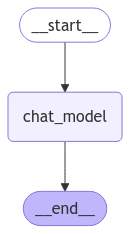

In [10]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Jamal

So you said you were researching Skardu, Pakistan?
================================ Human Message =================================
Name: Raheela

Yes, I know about Shigar Valley, hot springs , . But what others should I learn about?
================================== Ai Message ==================================

Skardu and its surrounding areas offer much more than Shigar Valley and hot springs! To give you a well-rounded picture, consider researching these aspects:

**Nature & Landscape:**

* **Deosai Plains:**  Often called the "Roof of the World," Deosai is a high-altitude plateau with stunning landscapes, diverse flora and fauna (including endangered species), and opportunities for trekking and camping.  It's a must-see if you're visiting the region.
* **Shangrila Resort:** A beautiful resort area nestled in a valley, offering scenic views and a tranquil atmosphere.
* **Katpana Desert:**

**rm notes**

[ Streaming ](https://langchain-ai.github.io/langgraph/concepts/streaming/#streaming-graph-outputs-stream-and-astream)

**Streaming LLM tokens and events (`.astream_events`)**

The **`.astream_events()`** method streams events in real-time as they occur within nodes, making it useful for tracking LLM token updates. It helps monitor and view these events during the graph's execution.

[RemoveMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.modifier.RemoveMessage.html)

RemoveMessage()

* id – The ID of the message to remove.

* kwargs – Additional fields to pass to the message.

In [12]:
async for m in graph.astream_events({'messages': messages}, version="v2"): # The version argument is now correctly passed as a keyword argument.
      print(m)
      print("\n--------------\n")

      # on_chain_start : start of a node's ececusion
      # on_chain_end : incdicates the completion of nodes's execusion
      # on_chain_stream : represent intermediate data or progress updates during a node's ececustion

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching Skardu, Pakistan?', additional_kwargs={}, response_metadata={}, name='Jamal', id='363c2ba1-907b-4f3f-b969-64598f5ec962'), HumanMessage(content='Yes, I know about Shigar Valley, hot springs , . But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Raheela', id='b7fa65ae-5512-4223-8217-51fe72fdca0d')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'acaafe2f-8276-471f-9e72-354c2acd2524', 'metadata': {}, 'parent_ids': []}

--------------

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching Skardu, Pakistan?', additional_kwargs={}, response_metadata={}, name='Jamal', id='363c2ba1-907b-4f3f-b969-64598f5ec962'), HumanMessage(content='Yes, I know about Shigar Valley, hot springs , . But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Raheela', id='b7fa6

## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/).

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

**rm notes**

Isolate messages to delete
**`delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]`**


```bash
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}
```

Through slicing get last 2 message
**`state["messages"][:-2]`**

save last 2 messages in messages
**`return {"messages": delete_messages}`**




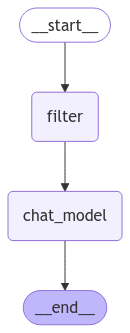

In [13]:
from langchain_core.messages import RemoveMessage
from langgraph.graph import MessagesState

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Jamal", id="1")]
messages.append(HumanMessage("Hi.", name="Raheela", id="2"))
messages.append(AIMessage("So you said you were researching Skardu, Pakistan?", name="Jamal", id="3"))
messages.append(HumanMessage("Yes, I know about Shigar Valley, hot springs. But what others should I learn about?", name="Raheela", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Jamal

So you said you were researching Skardu, Pakistan?
================================ Human Message =================================
Name: Raheela

Yes, I know about Shigar Valley, hot springs. But what others should I learn about?
================================== Ai Message ==================================

Excellent! Shigar Valley and its hot springs are definitely highlights of Skardu. To round out your knowledge, consider learning more about these aspects:

**Nature & Scenery:**

* **Shangrila Lake:** A stunningly beautiful lake, often photographed and a popular tourist destination.  Learn about its formation, the surrounding landscape, and any activities available there (boating, etc.).
* **Katpana Desert:**  A surprisingly arid desert landscape nestled amidst the mountains.  Understand its unique geographical location and how it contrasts with the surrounding region.
* **Deosai Plains

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

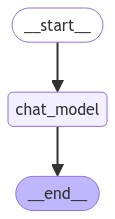

In [ ]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [ ]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [ ]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

In [ ]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

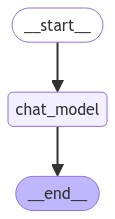

In [ ]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [ ]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', name='Lance')]

In [ ]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r